## Chuẩn bị: Import thư viện và tạo dữ liệu
Tái sử dụng code từ lab ANN để tạo dữ liệu huấn luyện và kiểm tra.

In [56]:
# Cài đặt thư viện
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Đặt seed để kết quả ổn định
torch.manual_seed(42)
np.random.seed(42)

In [57]:
# Tạo điểm cho lớp 0 (vòng tròn)
def generate_class_0(n_samples):
    u = np.random.uniform(0, 1, n_samples)
    theta = np.random.uniform(0, 2 * np.pi, n_samples)
    r = np.sqrt(u)  # Bán kính nhỏ
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

# Tạo điểm cho lớp 1 (vành đai)
def generate_class_1(n_samples):
    u = np.random.uniform(0, 1, n_samples)
    theta = np.random.uniform(0, 2 * np.pi, n_samples)
    r = np.sqrt(3 * u + 1)  # Bán kính lớn hơn
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

# Tạo dữ liệu
X_class0 = generate_class_0(100)
X_class1 = generate_class_1(200)
y_class0 = np.zeros(100)  # Nhãn 0
y_class1 = np.ones(200)   # Nhãn 1

# Kết hợp dữ liệu
X = np.vstack((X_class0, X_class1))
y = np.hstack((y_class0, y_class1))

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuyển sang tensor PyTorch
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(1)  # Thêm chiều cho nhãn
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

print(f"Kích thước tập train: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Kích thước tập test: X_test={X_test.shape}, y_test={y_test.shape}")

Kích thước tập train: X_train=torch.Size([240, 2]), y_train=torch.Size([240, 1])
Kích thước tập test: X_test=torch.Size([60, 2]), y_test=torch.Size([60, 1])


## Hàm huấn luyện và đánh giá chung

Để tránh lặp lại code, ta viết hàm huấn luyện và đánh giá dùng chung cho tất cả các phần.

In [58]:
def train_model(model, criterion, optimizer, X_train, y_train, epochs=100, use_sigmoid_for_pred=True):
    """Huấn luyện mô hình và trả về danh sách loss theo epoch."""
    loss_history = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()       # Xóa gradient cũ
        outputs = model(X_train)    # Dự đoán
        loss = criterion(outputs, y_train)  # Tính sai lầm
        loss.backward()             # Tìm cách sửa
        optimizer.step()            # Sửa trọng số
        loss_history.append(loss.item())
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], loss: {loss.item():.4f}")
    return loss_history


def evaluate_model(model, X_test, y_test, use_sigmoid_for_pred=True):
    """Đánh giá mô hình trên tập kiểm tra."""
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        if not use_sigmoid_for_pred:
            # Nếu mô hình không có Sigmoid (dùng BCEWithLogitsLoss),
            # áp dụng Sigmoid trước khi so sánh
            y_pred = torch.sigmoid(y_pred)
        y_pred = (y_pred > 0.5).float()  # Chuyển thành 0 hoặc 1
        accuracy = (y_pred.eq(y_test).sum() / y_test.size(0)).item()
    return accuracy

---

## Phần 1: Thay đổi cấu trúc ANN

### 1.1 Mô hình ban đầu (2-4-1) — Baseline

In [59]:
# Mô hình ANN ban đầu: 2-4-1
class ANN_4(nn.Module):
    def __init__(self):
        super(ANN_4, self).__init__()
        self.layer1 = nn.Linear(2, 4)  # Đầu vào 2, ẩn 4
        self.relu = nn.ReLU()          # Công tắc ReLU
        self.layer2 = nn.Linear(4, 1)  # Ẩn 4, đầu ra 1
        self.sigmoid = nn.Sigmoid()    # Xác suất 0-1

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

# Khởi tạo và huấn luyện
torch.manual_seed(42)
model_4 = ANN_4()
criterion_4 = nn.BCELoss()
optimizer_4 = optim.Adam(model_4.parameters(), lr=0.01)

print("=== Huấn luyện mô hình 2-4-1 ===")
loss_history_4 = train_model(model_4, criterion_4, optimizer_4, X_train, y_train)
acc_4 = evaluate_model(model_4, X_test, y_test)
print(f"\nLoss: {loss_history_4[-1]:.4f}")
print(f"Accuracy: {acc_4*100:.2f}%")

=== Huấn luyện mô hình 2-4-1 ===
Epoch [20/100], loss: 0.6049
Epoch [40/100], loss: 0.5641
Epoch [60/100], loss: 0.4728
Epoch [80/100], loss: 0.3899
Epoch [100/100], loss: 0.3316

Loss: 0.3316
Accuracy: 83.33%


### 1.2 Tăng số nút: Mô hình 2-8-1

Sửa lớp ẩn từ 4 nút thành 8 nút.

In [60]:
# Mô hình ANN với 8 nút ẩn: 2-8-1
class ANN_8(nn.Module):
    def __init__(self):
        super(ANN_8, self).__init__()
        self.layer1 = nn.Linear(2, 8)  # Đầu vào 2, ẩn 8
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(8, 1)  # Ẩn 8, đầu ra 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

# Khởi tạo và huấn luyện
torch.manual_seed(42)
model_8 = ANN_8()
criterion_8 = nn.BCELoss()
optimizer_8 = optim.Adam(model_8.parameters(), lr=0.01)

print("=== Huấn luyện mô hình 2-8-1 ===")
loss_history_8 = train_model(model_8, criterion_8, optimizer_8, X_train, y_train)
acc_8 = evaluate_model(model_8, X_test, y_test)
print(f"\nLoss: {loss_history_8[-1]:.4f}")
print(f"Accuracy: {acc_8*100:.2f}%")

=== Huấn luyện mô hình 2-8-1 ===
Epoch [20/100], loss: 0.5965
Epoch [40/100], loss: 0.5621
Epoch [60/100], loss: 0.5313
Epoch [80/100], loss: 0.4818
Epoch [100/100], loss: 0.4139

Loss: 0.4139
Accuracy: 70.00%


### 1.3 Thêm lớp ẩn: Mô hình 2-8-6-1

Thêm một lớp ẩn thứ hai với 6 nút, dùng ReLU.

In [61]:
# Mô hình ANN với 2 lớp ẩn: 2-8-6-1
class ANN_8_6(nn.Module):
    def __init__(self):
        super(ANN_8_6, self).__init__()
        self.layer1 = nn.Linear(2, 8)  # Đầu vào 2, ẩn 1: 8 nút
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(8, 6)  # Ẩn 1: 8, ẩn 2: 6 nút
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(6, 1)  # Ẩn 2: 6, đầu ra 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

# Khởi tạo và huấn luyện
torch.manual_seed(42)
model_8_6 = ANN_8_6()
criterion_8_6 = nn.BCELoss()
optimizer_8_6 = optim.Adam(model_8_6.parameters(), lr=0.01)

print("=== Huấn luyện mô hình 2-8-6-1 ===")
loss_history_8_6 = train_model(model_8_6, criterion_8_6, optimizer_8_6, X_train, y_train)
acc_8_6 = evaluate_model(model_8_6, X_test, y_test)
print(f"\nLoss: {loss_history_8_6[-1]:.4f}")
print(f"Accuracy: {acc_8_6*100:.2f}%")

=== Huấn luyện mô hình 2-8-6-1 ===
Epoch [20/100], loss: 0.5692
Epoch [40/100], loss: 0.4626
Epoch [60/100], loss: 0.3009
Epoch [80/100], loss: 0.1648
Epoch [100/100], loss: 0.0887

Loss: 0.0887
Accuracy: 98.33%


### 1.4 So sánh kết quả Phần 1

In [62]:
# Bảng so sánh
print(f"{'Mô hình':<20} {'Mất mát cuối':<20} {'Độ chính xác':<20}")
print(f"{'2-4-1':<20} {loss_history_4[-1]:<20.4f} {acc_4*100:<20.2f}%")
print(f"{'2-8-1':<20} {loss_history_8[-1]:<20.4f} {acc_8*100:<20.2f}%")
print(f"{'2-8-6-1':<20} {loss_history_8_6[-1]:<20.4f} {acc_8_6*100:<20.2f}%")

Mô hình              Mất mát cuối         Độ chính xác        
2-4-1                0.3316               83.33               %
2-8-1                0.4139               70.00               %
2-8-6-1              0.0887               98.33               %


### So sánh 3 mô hình (4 nút, 8 nút, 8+6 nút):
- loss: Tăng số nút hoặc thêm lớp ẩn thường làm loss giảm, vì mô hình có khả năng biểu diễn mạnh hơn và học được quan hệ phi tuyến tốt hơn.
- accuracy: Có xu hướng tăng nhẹ khi mô hình phức tạp hơn, nhưng với dữ liệu đơn giản, mô hình nhỏ đã đủ tốt. Mô hình lớn hơn có thể chính xác hơn nhưng dễ overfitting nếu dữ liệu ít.

---

## Phần 2: Thử nghiệm với hàm mất mát và tối ưu hóa

### 2.1 Dùng BCEWithLogitsLoss thay cho BCELoss

`BCEWithLogitsLoss` kết hợp Sigmoid và BCELoss trong một hàm, giúp tính toán ổn định hơn về mặt số học. Khi dùng hàm này, cần **xóa Sigmoid** khỏi lớp đầu ra.

In [63]:
# Mô hình ANN không có Sigmoid (dùng với BCEWithLogitsLoss): 2-4-1
class ANN_NoSigmoid(nn.Module):
    def __init__(self):
        super(ANN_NoSigmoid, self).__init__()
        self.layer1 = nn.Linear(2, 4)  # Đầu vào 2, ẩn 4
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(4, 1)  # Ẩn 4, đầu ra 1
        # KHÔNG có Sigmoid ở đầu ra!

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        # KHÔNG áp dụng Sigmoid, BCEWithLogitsLoss sẽ tự xử lý
        return x

# Khởi tạo và huấn luyện
torch.manual_seed(42)
model_logits = ANN_NoSigmoid()
criterion_logits = nn.BCEWithLogitsLoss()  # Thay BCELoss bằng BCEWithLogitsLoss
optimizer_logits = optim.Adam(model_logits.parameters(), lr=0.01)

print("=== Huấn luyện mô hình 2-4-1 với BCEWithLogitsLoss ===")
loss_history_logits = train_model(model_logits, criterion_logits, optimizer_logits, X_train, y_train)
acc_logits = evaluate_model(model_logits, X_test, y_test, use_sigmoid_for_pred=False)
print(f"\nMất mát cuối cùng: {loss_history_logits[-1]:.4f}")
print(f"Độ chính xác: {acc_logits*100:.2f}%")

=== Huấn luyện mô hình 2-4-1 với BCEWithLogitsLoss ===
Epoch [20/100], loss: 0.6049
Epoch [40/100], loss: 0.5641
Epoch [60/100], loss: 0.4728
Epoch [80/100], loss: 0.3899
Epoch [100/100], loss: 0.3316

Mất mát cuối cùng: 0.3316
Độ chính xác: 83.33%


### 2.2 Thay Adam bằng SGD

Quay lại cấu trúc ban đầu (2-4-1) với `nn.BCELoss()`, nhưng thay `optim.Adam` bằng `optim.SGD` với `lr=0.01`.

In [64]:
# Khởi tạo mô hình ban đầu 2-4-1 nhưng dùng SGD
torch.manual_seed(42)
model_sgd = ANN_4()
criterion_sgd = nn.BCELoss()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)  # Thay Adam bằng SGD

print("=== Huấn luyện mô hình 2-4-1 với SGD ===")
loss_history_sgd = train_model(model_sgd, criterion_sgd, optimizer_sgd, X_train, y_train)
acc_sgd = evaluate_model(model_sgd, X_test, y_test)
print(f"\nMất mát cuối cùng: {loss_history_sgd[-1]:.4f}")
print(f"Độ chính xác: {acc_sgd*100:.2f}%")

=== Huấn luyện mô hình 2-4-1 với SGD ===
Epoch [20/100], loss: 0.6255
Epoch [40/100], loss: 0.6250
Epoch [60/100], loss: 0.6246
Epoch [80/100], loss: 0.6242
Epoch [100/100], loss: 0.6238

Mất mát cuối cùng: 0.6238
Độ chính xác: 63.33%


### 2.3 So sánh kết quả Phần 2

In [65]:
# Bảng so sánh
print(f"{'Cấu hình':<30} {'Loss':<20} {'Accuracy':<20}")
print(f"{'2-4-1 + BCELoss + Adam':<30} {loss_history_4[-1]:<20.4f} {acc_4*100:<20.2f}%")
print(f"{'2-4-1 + BCEWithLogits + Adam':<30} {loss_history_logits[-1]:<20.4f} {acc_logits*100:<20.2f}%")
print(f"{'2-4-1 + BCELoss + SGD':<30} {loss_history_sgd[-1]:<20.4f} {acc_sgd*100:<20.2f}%")

Cấu hình                       Loss                 Accuracy            
2-4-1 + BCELoss + Adam         0.3316               83.33               %
2-4-1 + BCEWithLogits + Adam   0.3316               83.33               %
2-4-1 + BCELoss + SGD          0.6238               63.33               %


### So sánh kết quả
- **BCEWithLogitsLoss vs BCELoss:**
Hai cách cho kết quả gần như tương đương về lý thuyết. Tuy nhiên, BCEWithLogitsLoss ổn định số học hơn vì gộp Sigmoid + BCE trong một bước, nên thường được ưu tiên dùng.

- **SGD vs Adam:**
Adam hội tụ nhanh hơn và thường đạt loss thấp, accuracy cao hơn trong ít epoch nhờ adaptive learning rate.
SGD hội tụ chậm hơn, nhưng có thể đạt kết quả tương đương nếu train lâu hơn hoặc chỉnh learning rate phù hợp.

---

## Phần 3: Phân tích kết quả

### 3.1 Vẽ đồ thị mất mát theo epoch

Vẽ 3 đường loss trên cùng một đồ thị:
- Cấu trúc ban đầu (2-4-1, Adam, BCELoss)
- Cấu trúc 2-8-1 (Adam, BCELoss)
- Cấu trúc 2-4-1 (SGD, BCELoss)

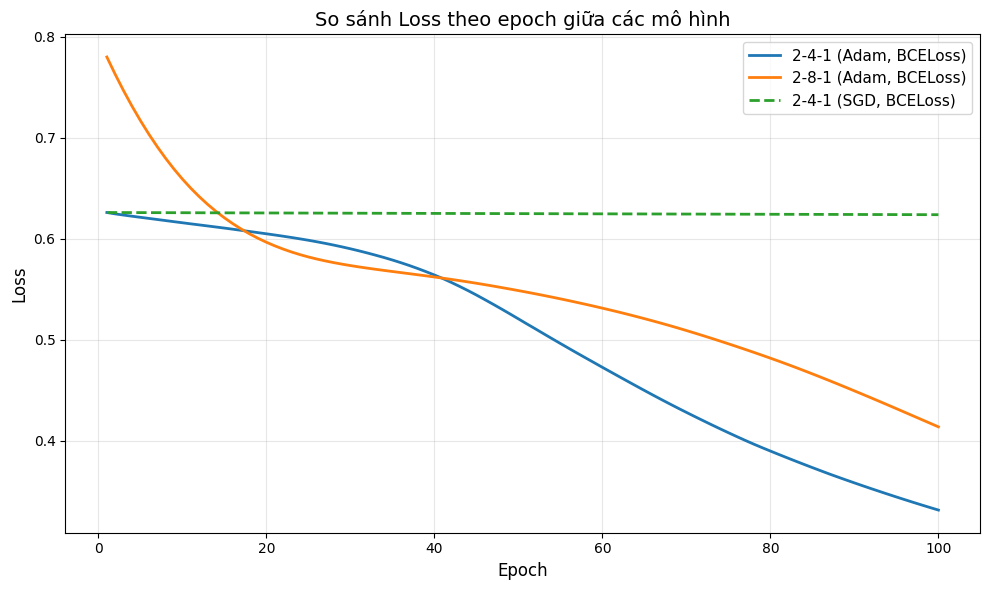

In [66]:
# Vẽ đồ thị mất mát
plt.figure(figsize=(10, 6))

epochs_range = range(1, 101)

plt.plot(epochs_range, loss_history_4, label='2-4-1 (Adam, BCELoss)', linewidth=2)
plt.plot(epochs_range, loss_history_8, label='2-8-1 (Adam, BCELoss)', linewidth=2)
plt.plot(epochs_range, loss_history_sgd, label='2-4-1 (SGD, BCELoss)', linewidth=2, linestyle='--')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('So sánh Loss theo epoch giữa các mô hình', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### So sánh kết quả

**Giảm nhanh nhất:** 2-8-1 với Adam (optimizer thích ứng + nhiều tham số hơn → học nhanh).

**Giảm chậm nhất:** 2-4-1 với SGD (learning rate cố định → cập nhật chậm hơn).

**Dao động loss:**
- SGD dễ dao động do learning rate cố định.
- Adam giảm mượt hơn nhờ cơ chế adaptive dùng moments của gradient.